#Libraries and Dates

In [67]:
#install libraries
!pip install yfinance
!pip install tfcausalimpact

In [2]:
#import libraries
import yfinance as yf
from causalimpact import CausalImpact
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [87]:
#Dates
training_start = "2021-09-20"
training_end = "2024-08-19"
treatment_start = "2024-08-26"
treatment_end = "2024-09-02"
end_stock = "2024-09-05"

#Loading financial data

In [88]:
#CPO
y = ["SIMP.JK"]
y = yf.download(tickers = y,
                start = training_start,
                end = end_stock,
                interval = "1wk")
y = y['Adj Close'].rename("y")
y[:1]

[*********************100%***********************]  1 of 1 completed


,y
Date,
2021-09-20,369.40509


In [105]:
#Load more stock data
stocks = ["MYOR.JK", "ICBP.JK", "ROTI.JK", "JPFA.JK","ULTJ.JK","INDF.JK","UNVR.JK","ADRO.JK"]
X = yf.download(tickers = stocks,
                start = training_start,
                end = end_stock,
                interval = "1wk")


[*********************100%***********************]  8 of 8 completed


#Data Preparation

In [106]:
#Getting the adjusted close
X = X.iloc[:, :len(stocks)]
X.head(1)

Price                       Adj Close                                         \
Ticker                        ADRO.JK      ICBP.JK      INDF.JK      JPFA.JK   
Date                                                                           
2021-09-20 00:00:00+00:00  962.382996  7812.732422  5453.202637  1708.084839   

Price                                                                          
Ticker                         MYOR.JK      ROTI.JK      ULTJ.JK      UNVR.JK  
Date                                                                           
2021-09-20 00:00:00+00:00  2289.592041  1113.471802  1449.130737  3511.285889

In [107]:
#Removing level
X.columns = X.columns.droplevel()
X.head(1)

Ticker,ADRO.JK,ICBP.JK,INDF.JK,JPFA.JK,MYOR.JK,ROTI.JK,ULTJ.JK,UNVR.JK
Date,,,,,,,,
2021-09-20 00:00:00+00:00,962.382996,7812.732422,5453.202637,1708.084839,2289.592041,1113.471802,1449.130737,3511.285889


In [108]:
#Time zones
X.index = X.index.tz_localize(None)
X.index

DatetimeIndex(['2021-09-20', '2021-09-27', '2021-10-04', '2021-10-11',
               '2021-10-18', '2021-10-25', '2021-11-01', '2021-11-08',
               '2021-11-15', '2021-11-22',
               ...
               '2024-07-01', '2024-07-08', '2024-07-15', '2024-07-22',
               '2024-07-29', '2024-08-05', '2024-08-12', '2024-08-19',
               '2024-08-26', '2024-09-02'],
              dtype='datetime64[ns]', name='Date', length=155, freq=None)

In [109]:
#Combine everything
df = pd.concat([y, X], axis = 1).dropna()
df.head()

,y,ADRO.JK,ICBP.JK,INDF.JK,JPFA.JK,MYOR.JK,ROTI.JK,ULTJ.JK,UNVR.JK
Date,,,,,,,,,
2021-09-20,369.405090,962.382996,7812.732422,5453.202637,1708.084839,2289.592041,1113.471802,1449.130737,3511.285889
2021-09-27,413.381927,1142.027832,7836.265137,5541.872070,1735.634644,2251.432129,1101.053955,1453.866455,3413.996094
2021-10-04,438.008972,1164.483398,8377.508789,5940.887207,1703.493164,2308.671875,1080.357422,1482.280762,4210.005371
2021-10-11,436.249878,1193.354736,8730.494141,6007.389648,1708.084839,2451.771240,1080.357422,1477.545166,4621.277832
2021-10-18,422.177277,1113.156372,8565.767578,5896.551758,1717.268066,2299.131836,1138.307617,1539.109619,4289.606445


#Data Analysis section

In [110]:
#Prepare a dataframe with only training data
df_training = df[df.index <= training_end]
df_training.tail(1)

,y,ADRO.JK,ICBP.JK,INDF.JK,JPFA.JK,MYOR.JK,ROTI.JK,ULTJ.JK,UNVR.JK
Date,,,,,,,,,
2024-08-19,384.0,3470.0,11475.0,6700.0,1580.0,2680.0,1055.0,1825.0,2350.0


In [111]:
#Stationarity
from statsmodels.tsa.stattools import adfuller
test = adfuller(x = df_training.y)[1]

#how to read - ifelse
if test < 0.05:
  print("The Time Series is stationary")
else:
  print("The Time Series is not stationary")

The Time Series is not stationary


In [112]:
#Differencing: subtract or divide
differencing = df_training.pct_change().dropna()
differencing.head(2)

,y,ADRO.JK,ICBP.JK,INDF.JK,JPFA.JK,MYOR.JK,ROTI.JK,ULTJ.JK,UNVR.JK
Date,,,,,,,,,
2021-09-27,0.119048,0.186667,0.003012,0.01626,0.016129,-0.016667,-0.011152,0.003268,-0.027708
2021-10-04,0.059575,0.019663,0.069069,0.07200,-0.018519,0.025424,-0.018797,0.019544,0.233161


In [113]:
#Stationarity
from statsmodels.tsa.stattools import adfuller
test = adfuller(x = differencing.y)[1]

#how to read - ifelse
if test < 0.05:
  print("The Time Series is stationary")
else:
  print("The Time Series is not stationary")

The Time Series is stationary


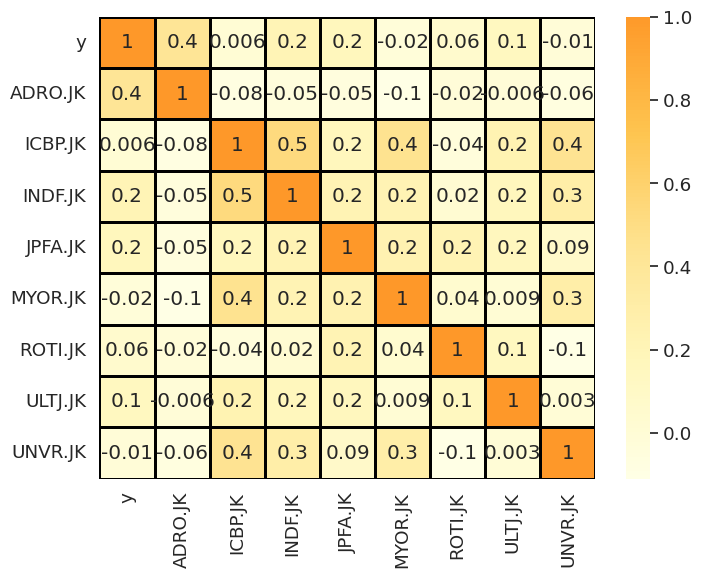

In [114]:
#Correlation Matrix
plt.figure(figsize = (8,6))
sns.set(font_scale = 1.2)
sns.heatmap(differencing.corr(),
            annot = True,
            fmt = '.1g',
            cmap = 'YlOrBr',
            center =  True,
            linewidth = 1,
            linecolor = 'black')
plt.show()

#Causal Impact

In [115]:
df_final = df.drop(columns = ["ADRO.JK","JPFA.JK","ROTI.JK","ULTJ.JK","UNVR.JK"])
df_final.head(1)

,y,ICBP.JK,INDF.JK,MYOR.JK
Date,,,,
2021-09-20,369.40509,7812.732422,5453.202637,2289.592041


In [116]:
#Pre and post period
pre_period = [training_start, training_end]
post_period = [treatment_start, treatment_end] # Changed the end date to the last date available in the DataFrame

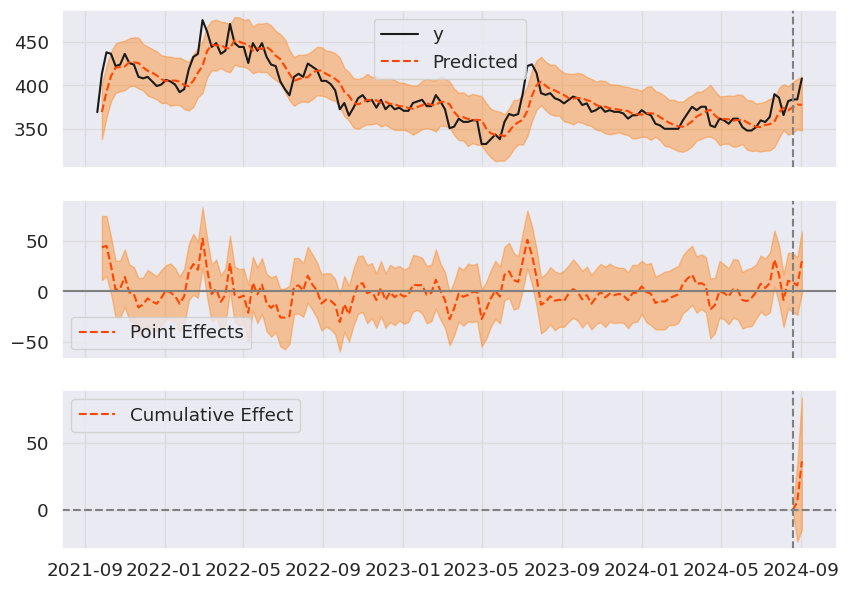

In [117]:
#Google Causal Impact
impact = CausalImpact(data = df_final,
                      pre_period = pre_period,
                      post_period = post_period)
impact.plot()

In [118]:
#Summary
print(impact.summary())
#1634

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    396.0              792.0
Prediction (s.d.)         377.93 (11.88)     755.86 (23.76)
95% CI                    [353.74, 400.32]   [707.48, 800.64]

Absolute effect (s.d.)    18.07 (11.88)      36.14 (23.76)
95% CI                    [-4.32, 42.26]     [-8.64, 84.52]

Relative effect (s.d.)    4.78% (3.14%)      4.78% (3.14%)
95% CI                    [-1.14%, 11.18%]   [-1.14%, 11.18%]

Posterior tail-area probability p: 0.05
Posterior prob. of a causal effect: 94.51%

For more details run the command: print(impact.summary('report'))


In [119]:
#Summary report
print(impact.summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 396.0. In the absence of an
intervention, we would have expected an average response of 377.93.
The 95% interval of this counterfactual prediction is [353.74, 400.32].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 18.07 with a 95% interval of
[-4.32, 42.26]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 792.0.
Had the intervention not taken place, we would have expected
a sum of 755.86. The 95% interval of this prediction is [707.48, 800.64].


The above results are given in terms of absolute numbers. In relative
terms, the response variable showed an increase of